In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import json
#import plotly.graph_objects as go

In [17]:
file_path_2 = '/volatile/halla/sbs/bhasitha/data-5.json'  # Update to the actual path if different

# Read the JSON file and parse it into a list
with open(file_path_2, 'r') as json_file_2:
    data_list_2 = json.load(json_file_2)

In [18]:
data_list = data_list_2

In [19]:
import torch
import numpy as np
import torch
import torch_geometric
from torch_geometric.data import Data
from scipy.spatial.distance import cdist

processed_data_list = []

for event_data in data_list:
    if 10<len(event_data['target'])<172:

      event = torch.tensor(event_data['event'], dtype=torch.float)
      #coordinates_tensor = torch.tensor(event_data['coordinates'], dtype=torch.float32)
      coordinates_2D_tensor = torch.tensor(event_data['coordinates_2D'], dtype=torch.float)
      coordinates_3D_tensor = torch.tensor(event_data['coordinates_3D'], dtype=torch.float)
      target_tensor = torch.tensor(event_data['target'], dtype=torch.int64)
      edge_index_tensor_test = torch.tensor(event_data['edge_index'], dtype=torch.int64)
      layer_tensor = torch.tensor(event_data['layer'], dtype=torch.int64)

      slopes = []

# Iterate through each element in array1 and array2
      for y_coor, z_coor, layer in zip([row[1] for row in event_data['coordinates_3D']], [row[2] for row in event_data['coordinates_3D']], event_data['layer']):
        if layer == 0:
          slopes.append( (y_coor+0.0422169) / 2.951 )
        elif layer == 1:
          slopes.append( (y_coor+0.0422169) / (2.951 + z_coor))
        elif layer == 2:
          slopes.append( (y_coor+0.0422169) / (2.951 + z_coor))
        elif layer == 3:
          slopes.append( (y_coor+0.0422169) / (2.951 + z_coor))

      slopes_tensor = torch.tensor(slopes, dtype=torch.float)

      # Concatenate the tensors along the second dimension
      hybrid_tensor = torch.cat((coordinates_2D_tensor, slopes_tensor.view(-1, 1)), dim=1)

      #print(coordinates_3D_tensor)
      #print(target_tensor)
      #print(slopes_tensor)
      #print()


#### ########### ########### ########### ########### ########### ########### ########### ###########
#### ########### EDGE INDEX MASKING for NO EDGES WITHIN THE SAME LAYER ##### ########### ###########
#### ########### ########### ########### ########### ########### ########### ########### ###########

      edge_index_mask = layer_tensor[edge_index_tensor_test[0]] == layer_tensor[edge_index_tensor_test[1]]
      edge_index_tensor = edge_index_tensor_test[:, ~edge_index_mask]

#### ########### ########### ########### ########### ########### ########### ########### ###########
#### ########### EDGE INDEX MASKING for NO EDGES WITHIN THE SAME LAYER ##### ########### ###########
#### ########### ########### ########### ########### ########### ########### ########### ###########

      consecutive_ones = torch.where(target_tensor == 1)[0]
      edges = []
      for i in range(len(consecutive_ones) - 1):
          edges.append([consecutive_ones[i], consecutive_ones[i + 1]])
      edge_index = torch.tensor(edges).t()

      #edge_index_tensor_can = torch.tensor(event_data['edge_index'], dtype=torch.int64)
      edge_index_tensor_can = (edge_index_tensor) #(event_data['edge_index'])

      try:
        num_nodes = edge_index_tensor_can.max().item() + 1
      except ZeroDivisionError:
        print("Error: No negative edges. Skipping this graph")
        print(edges_set)
        print(filtered_edge_index_tensor)
        continue
      ## num_nodes = edge_index_tensor_can.max().item() + 1

      # Create a set to keep track of visited edges
      visited_edges = set()

      # Create a list to store filtered edges
      filtered_edges = []

      # Iterate through each edge
      for edge in edge_index_tensor_can.T:
          src, dest = edge.tolist()
          # Check if the reverse edge has been visited
          if (dest, src) not in visited_edges:
              visited_edges.add((src, dest))
              filtered_edges.append(edge)

      # Convert the filtered edges back to a tensor
      filtered_edge_index_tensor = torch.stack(filtered_edges).T#torch.tensor(filtered_edges).T


      set_edge_can = set(map(tuple, filtered_edge_index_tensor.T.tolist()))
      set_egde_index = set(map(tuple, edge_index.T.tolist()))

      set_neg_edge_index = set_edge_can - set_egde_index
      neg_edges = torch.tensor(list(set_neg_edge_index)).T

      edges_set = {tuple(e.tolist()) for e in edge_index.t()}

      # Filter out edges that need to be removed
      filtered_edges = [e for e in filtered_edge_index_tensor if tuple(e.tolist()) not in edges_set]

      edge_y = torch.nonzero((filtered_edge_index_tensor[0].unsqueeze(1) == edge_index[0]) & (filtered_edge_index_tensor[1].unsqueeze(1) == edge_index[1]), as_tuple=False)[:, 0]
      # Convert indices to a list
      edge_y_tensor = torch.tensor(edge_y.tolist(), dtype=torch.int64)

      try:
        edge_y_neg = torch.nonzero((filtered_edge_index_tensor[0].unsqueeze(1) == neg_edges[0]) & (filtered_edge_index_tensor[1].unsqueeze(1) == neg_edges[1]), as_tuple=False)[:, 0]
      except IndexError:
        print("Error: IndexError")
        print(edges_set)
        print(filtered_edge_index_tensor)
        continue

      edge_y_neg_ensor = torch.tensor(edge_y_neg.tolist(), dtype=torch.int64)


      #print(edges_set)
      #print(filtered_edges)
      #print()

      # Convert filtered_edges back to a tensor

      try:
        edge_index_neg = 0 / len(neg_edges)
      except ZeroDivisionError:
        print("Error: Zero divition error")
        print(edges_set)
        print(filtered_edge_index_tensor)
        continue
      except RuntimeError:
        print("Error: No negative edges. Skipping this graph")
        print(edges_set)
        print(filtered_edge_index_tensor)
        continue



      '''
      print(edge_index)
      print(neg_edges)
      print(filtered_edge_index_tensor)
      print(layer_tensor)
      print()
      '''
      data = Data(
          event=event,
          #x=coordinates_tensor,
          x_2d=coordinates_2D_tensor,
          y=target_tensor,
          edge_index=edge_index,
          edge_index_neg = neg_edges,
          edge_index_can=filtered_edge_index_tensor,
          edge_y = edge_y_tensor,
          edge_y_neg = edge_y_neg_ensor,
          layer=layer_tensor,
          slopes=slopes_tensor,
          x_2d_with_slopes = hybrid_tensor
      )

      processed_data_list.append(data)

Error: IndexError
{(11, 12), (0, 8), (8, 11)}
tensor([[ 0,  8, 11],
        [ 8, 11, 12]])
Error: IndexError
{(0, 18), (19, 21), (18, 19)}
tensor([[ 0, 18, 19],
        [18, 19, 21]])
Error: IndexError
{(0, 1), (1, 6), (6, 7)}
tensor([[0, 1, 6],
        [1, 6, 7]])


In [20]:
len(processed_data_list)

9815

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader

In [22]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_max_pool
from torch_geometric.nn import GATConv
from torch_geometric.nn import GINConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.utils import add_self_loops, degree

# Load a dataset (you can replace this with your own dataset)
dataset = processed_data_list.copy()
#graph = dataset[0]
#num_nodes = graph.number_of_nodes()

scaler = StandardScaler()

# Assuming 'dataset' is a list of Data objects
for data in dataset:
    # Perform normalization
    data.x_2d = scaler.fit_transform(data.x_2d)  # Example of standardization
    # Convert the normalized data back to PyTorch tensors
    data.x_2d = torch.tensor(data.x_2d, dtype=torch.float32)  # Adjust dtype as needed

    data.x_2d_with_slopes = scaler.fit_transform(data.x_2d_with_slopes)  # Example of standardization
    # Convert the normalized data back to PyTorch tensors
    data.x_2d_with_slopes = torch.tensor(data.x_2d_with_slopes, dtype=torch.float32)  # Adjust dtype as needed



dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Split your dataset into training and validation sets
train_dataset, val_dataset = train_test_split(processed_data_list, test_size=0.2, random_state=42)

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

'''
# Load a dataset (you can replace this with your own dataset)
dataset = processed_data_list
#graph = dataset[0]
#num_nodes = graph.number_of_nodes()
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
'''
'''
class SAGEConvWithAttention(SAGEConv):
    def __init__(self, in_channels, out_channels):
        super(SAGEConvWithAttention, self).__init__(in_channels, out_channels, aggr='add')

        self.attention = torch.nn.Linear(in_channels * 2, 1)

    def message(self, x_j):
        alpha = self.attention(torch.cat([x_j, x_j], dim=-1))  # Concatenate x_j with itself for simplicity
        alpha = F.softmax(alpha, dim=0)
        return alpha * x_j

# Usage in your GraphSAGELinkPrediction class
class GraphSAGELinkPrediction(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGELinkPrediction, self).__init__()
        self.conv1 = SAGEConvWithAttention(in_feats, h_feats) #SAGEConv(in_feats, h_feats, aggr='max')
        self.conv2 = SAGEConv(h_feats, h_feats * 2, aggr='min')
        self.conv3 = SAGEConv(h_feats * 2, h_feats * 2, aggr='max')
        self.conv4 = SAGEConv(h_feats * 2, h_feats, aggr='min')
        #self.link_predictor = LinkPredictor(h_feats * 2, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        return x
'''
class SAGEConvWithAttention(SAGEConv):
    def __init__(self, in_channels, out_channels):
        super(SAGEConvWithAttention, self).__init__(in_channels, out_channels, aggr='min')

        self.attention = torch.nn.Linear(in_channels, 1)

    def message(self, x_j):
        alpha = self.attention(x_j)
        alpha = F.softmax(alpha, dim=1)  # Softmax along the last dimension
        return alpha * x_j


class GraphSAGELinkPrediction(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGELinkPrediction, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats)
        # LSTM layer
        self.lstm = nn.LSTM(h_feats, h_feats * 2, batch_first=False)
        self.lstm = nn.LSTM(h_feats * 2, h_feats * 2, batch_first=False)
        self.conv3 = SAGEConv(h_feats * 2, h_feats * 2, aggr='max')
        self.conv4 = SAGEConv(h_feats * 2, h_feats, aggr='max')

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        # Reshaping the input for LSTM
        #x = x.unsqueeze(0)  # Add a batch dimension
        x, _ = self.lstm(x)
        x, _ = self.lstm(x)
        #x = x.squeeze(0)  # Remove the batch dimension
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        return x

class GraphSAGELinkPrediction(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGELinkPrediction, self).__init__()
        self.conv1 = SAGEConvWithAttention(in_feats, h_feats)
        # LSTM layer
        self.lstm1 = nn.LSTM(h_feats, h_feats * 2, batch_first=False)
        #self.lstm2 = nn.LSTM(h_feats * 2, h_feats * 2, batch_first=False)
        self.conv3 = SAGEConv(h_feats * 2, h_feats * 2, aggr='max')
        self.conv4 = SAGEConv(h_feats * 2, h_feats, aggr='max')

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))

        # Reshaping the input for LSTM
        x = x.unsqueeze(0)  # Add a batch dimension
        x, _ = self.lstm1(x)
        #x, _ = self.lstm2(x)
        self.lstm1.train()
        x = x.squeeze(0)  # Remove the batch dimension
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        return x


class LinkPredictor(nn.Module):
    def __init__(self, emb_dim):
        super(LinkPredictor, self).__init__()
        self.fc1 = nn.Linear(emb_dim * 2, 16)  # Example: 128 is the hidden layer size
        self.fc2 = nn.Linear(16, 8)  # Example: Add additional layers as needed
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, 1)  # The final layer for binary classification

    def forward(self, src_emb, dst_emb):
        combined_emb = torch.cat((src_emb, dst_emb), dim=-1)
        x = F.relu(self.fc1(combined_emb))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        pred = torch.sigmoid(self.fc4(x))
        return pred

In [23]:
in_feats = 3
h_feats = 128
emb_dim = h_feats
emb_dim_2 = h_feats
num_classes = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gcn_model = GraphSAGELinkPrediction(in_feats, h_feats, num_classes).to(device)
link_predictor = LinkPredictor(emb_dim).to(device)

# Define optimizer
optimizer = optim.Adam(list(gcn_model.parameters()) + list(link_predictor.parameters()), lr=0.0005, weight_decay=1e-5)
#optimizer = optim.SGD(list(gcn_model.parameters()) + list(link_predictor.parameters()), lr=0.001)
#optimizer = optim.RMSprop(list(gcn_model.parameters()) + list(link_predictor.parameters()), lr=0.001, alpha=0.9)

optimizer_1 = optim.Adam(list(gcn_model.parameters()), lr=0.001)
optimizer_2 = optim.Adam(list(link_predictor.parameters()), lr=0.001)

'''

in_feats = 2
h_feats = 128
num_classes = 1
gcn_model = GCNLinkPrediction(in_feats, h_feats, num_classes)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
'''

'\n\nin_feats = 2\nh_feats = 128\nnum_classes = 1\ngcn_model = GCNLinkPrediction(in_feats, h_feats, num_classes)\noptimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001)\ncriterion = nn.BCEWithLogitsLoss()\n'

In [24]:
# Layer Masked Model

num_epochs = 600

gcn_model.train()
link_predictor.train()

train_pos_accuracy_withEpochs = []
train_neg_accuracy_withEpochs = []
train_accuracy_withEpochs = []

val_pos_accuracy_withEpochs = []
val_neg_accuracy_withEpochs = []
val_accuracy_withEpochs = []

train_loss_withEpochs = []
val_loss_withEpochs = []

gcn_model.cuda()
link_predictor.cuda()

for epoch in range(num_epochs):
  train_losses = []

  train_losses = []
  correct_predictions = 0
  total_predictions = 0
  correct_pos_predictions = 0
  correct_neg_predictions = 0
  total_pos_predictions = 0
  total_neg_predictions = 0

  for data in train_dataloader:
      data = data.to('cuda')
      optimizer.zero_grad()

      node_emb = gcn_model(data.x_2d_with_slopes, data.edge_index_can)
      #node_emb = gcn_model(data.x_2d, data.edge_index_can)
      pos_edge = data.edge_index_can

      src_emb = node_emb[pos_edge[0]]
      dst_emb = node_emb[pos_edge[1]]

      pred = link_predictor(src_emb, dst_emb)
      #pos_src, pos_dst = data.edge_index[0], data.edge_index[1]
      #neg_src, neg_dst = data.edge_index_neg[0], data.edge_index_neg[1]

      pos_pred = pred[data.edge_y]
      neg_pred = pred[data.edge_y_neg]

############################    LAYER MASKING START   ######################################
############################################################################################

      #same_layer_mask_pos = data.layer[pos_edge[0]] == data.layer[pos_edge[1]]
      #same_layer_mask_neg = data.layer[neg_src] == data.layer[neg_dst]

      # Calculate the loss for positive examples while excluding same-layer links


      ## loss_pos_filtered = -torch.log(pos_pred + 1e-15)
      # loss_pos_filtered = -len(data.edge_index_neg[0]) * torch.log(pos_pred + 1e-15)
      loss_pos_filtered = - torch.log(pos_pred + 1e-15)


      ## loss_pos_filtered = loss_pos[~same_layer_mask_pos]  # Filter out same-layer links
      loss_pos_mean = loss_pos_filtered.sum()

      # Calculate the loss for negative examples while excluding same-layer links


      ## loss_neg_filtered = -torch.log(1 - neg_pred + 1e-15)
      # loss_neg_filtered = -len(data.edge_index[0]) * torch.log(1 - neg_pred + 1e-15)
      loss_neg_filtered = -torch.log(1 - neg_pred + 1e-15)


      ## loss_neg_filtered = loss_neg[~same_layer_mask_neg]  # Filter out same-layer links
      loss_neg_mean = loss_neg_filtered.sum()


      # Calculate the overall loss
      #loss = (loss_pos_mean + loss_neg_mean)/(len(data.edge_index[0]) + len(data.edge_index_neg[0]))
      loss = 2 * (loss_pos_mean / len(data.edge_index[0])) + 2 * (loss_neg_mean / len(data.edge_index_neg[0]))


      #loss_pos = nn.BCELoss()(pos_pred, torch.ones_like(pos_pred))

      # Calculate the binary cross-entropy loss for negative examples
      #loss_neg = nn.BCELoss()(neg_pred, torch.zeros_like(neg_pred))

      # Calculate the overall loss
      #loss = (loss_pos + loss_neg) * 2



############################    3 LINK MAX PREDICTION   ######################################
##############################################################################################
      # if epoch > 25:
      #   pos_pred_num = (pos_pred > 0.5).sum().item() + (neg_pred > 0.5).sum().item()
      #   loss = loss * ((neg_pred > 0.5).sum().item()/len((neg_pred)))

############################    3 LINK MAX PREDICTION END  ######################################
#################################################################################################

############################    LAYER MASKING END   ######################################
##########################################################################################




      #loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()
      #loss = -torch.log(pos_pred + 1e-15).mean() #- torch.log(1 - neg_pred + 1e-15).mean()

      ## loss = torch.mean(torch.ones_like(pos_pred) - pos_pred) + torch.mean(neg_pred)

      #loss = nn.BCELoss()(torch.cat((pos_pred, neg_pred)), torch.cat((torch.ones_like(pos_pred), torch.zeros_like(neg_pred))))

      loss.backward()
      optimizer.step()
      ## 0ptimizer_1.step()
      ## optimizer_2.step()

      ## train_losses.append(loss.item())
      train_losses.append(loss)

      pos_count = (pos_pred > 0.5).sum().item() #/ len(pos_pred)
      neg_count = (neg_pred < 0.5).sum().item() #/ len(neg_pred)

      correct_pos_predictions += pos_count
      correct_neg_predictions += neg_count
      correct_predictions += (pos_count + neg_count)

      total_pos_predictions += len(pos_pred)
      total_neg_predictions += len(neg_pred)
      total_predictions += (len(pos_pred) + len(neg_pred))

  pos_accuracy = correct_pos_predictions/total_pos_predictions
  neg_accuracy = correct_neg_predictions/total_neg_predictions
  accuracy = correct_predictions / total_predictions



######## ######## ######## ########   VALIDATION START   ######## ######## ######## ########
######## ######## ######## ######## ########    ######## ######## ######## ######## ########

  ## VALIDATION

  gcn_model.eval()
  link_predictor.eval()

  val_losses = []
  correct_val_predictions = 0
  total_val_predictions = 0
  correct_pos_val_predictions = 0
  correct_neg_val_predictions = 0
  total_pos_val_predictions = 0
  total_neg_val_predictions = 0

  for data in val_dataloader:
    data = data.to('cuda')
    node_emb = gcn_model(data.x_2d_with_slopes, data.edge_index_can)
    #node_emb = gcn_model(data.x_2d, data.edge_index_can)
    pos_edge = data.edge_index_can

    src_emb = node_emb[pos_edge[0]]
    dst_emb = node_emb[pos_edge[1]]

    pred = link_predictor(src_emb, dst_emb)
    #pos_src, pos_dst = data.edge_index[0], data.edge_index[1]
    #neg_src, neg_dst = data.edge_index_neg[0], data.edge_index_neg[1]

    pos_pred = pred[data.edge_y]
    neg_pred = pred[data.edge_y_neg]

    loss = torch.mean(torch.ones_like(pos_pred) - pos_pred) + torch.mean(neg_pred)

    val_losses.append(loss.item())

    pos_count = (pos_pred > 0.5).sum().item()
    neg_count = (neg_pred < 0.5).sum().item()

    correct_pos_val_predictions += pos_count
    correct_neg_val_predictions += neg_count
    correct_val_predictions += (pos_count + neg_count)

    total_pos_val_predictions += len(pos_pred)
    total_neg_val_predictions += len(neg_pred)
    total_val_predictions += (len(pos_pred) + len(neg_pred))

    correct_val_predictions += (pos_count + neg_count)
    total_val_predictions += (len(pos_pred) + len(neg_pred))

  pos_val_accuracy = correct_pos_val_predictions/total_pos_val_predictions
  neg_val_accuracy = correct_neg_val_predictions/total_neg_val_predictions
  val_accuracy = correct_val_predictions / total_val_predictions


  avg_val_loss = sum(val_losses) / len(val_losses)
  avg_train_loss = sum(train_losses) / len(train_losses)

######## ######## ########   VALIDATION END  ######## ######## ########
######## ######## ######## ######## ######## ######## ######## ########

  train_pos_accuracy_withEpochs.append(pos_accuracy)
  train_neg_accuracy_withEpochs.append(neg_accuracy)

  val_pos_accuracy_withEpochs.append(pos_val_accuracy)
  val_neg_accuracy_withEpochs.append(neg_val_accuracy)

  train_accuracy_withEpochs.append(accuracy)
  val_accuracy_withEpochs.append(val_accuracy)

  train_loss_withEpochs.append(avg_train_loss)
  val_loss_withEpochs.append(avg_val_loss)

######## ######## ########    PRINT RESULTS   ######## ######## ########
######## ######## ######## ########  ######## ######## ######## ########

  '''
  print(data.edge_index)
  print(pos_pred)
  print(neg_pred[0:8])

  if epoch % 15 == 0:
    print("pos pred: ", pos_pred)
    print("neg pred: ", neg_pred)


  print("loss:", loss)
  print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_train_loss:.4f} | Pos Accuracy: {pos_accuracy:.4f} | Neg Accuracy: {neg_accuracy:.4f}')
  print()
  '''

  print(data.edge_index)
  print(pos_pred)
  print(neg_pred[0:8])
  print(f'Epoch [{epoch+1}/{num_epochs}] | Training Loss: {avg_train_loss:.4f} | Training Pos Accuracy: {pos_accuracy:.4f} | Training Neg Accuracy: {neg_accuracy:.4f} | Training Total Accuracy: {accuracy:.4f}')

  print(f'Validation - Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_val_loss:.4f} | Val Pos Accuracy: {pos_val_accuracy:.4f} | Val Neg Accuracy: {neg_val_accuracy:.4f} | Val Total Accuracy: {val_accuracy:.4f}')
  print()

/opt/conda/lib/python3.8/site-packages/torch_geometric/data/storage.py:280: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'slopes', 'y', 'x_2d', 'layer', 'edge_y', 'x_2d_with_slopes', 'edge_index_can', 'edge_y_neg', 'edge_index', 'edge_index_neg', 'event'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor([[ 2, 15, 25],
        [15, 25, 32]], device='cuda:0')
tensor([[0.9357],
        [0.9753],
        [0.9009]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([[4.2432e-01],
        [2.6092e-06],
        [2.8879e-06],
        [5.3738e-03],
        [2.2315e-04],
        [1.0436e-05],
        [1.3649e-03],
        [8.1243e-03]], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch [1/600] | Training Loss: 1.4879 | Training Pos Accuracy: 0.8702 | Training Neg Accuracy: 0.8113 | Training Total Accuracy: 0.8124
Validation - Epoch [1/600] | Loss: 0.2096 | Val Pos Accuracy: 0.9603 | Val Neg Accuracy: 0.9212 | Val Total Accuracy: 0.9219

tensor([[ 2, 15, 25],
        [15, 25, 32]], device='cuda:0')
tensor([[0.8023],
        [0.9736],
        [0.8567]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([[3.8966e-02],
        [3.8832e-08],
        [1.0949e-08],
        [1.8161e-04],
        [2.0958e-06],
        [3.5780e-09],
        [1.2401e-03],
        [4.6276e-04]], device='cuda:0', grad

KeyboardInterrupt: 

AttributeError: 'list' object has no attribute 'detach'

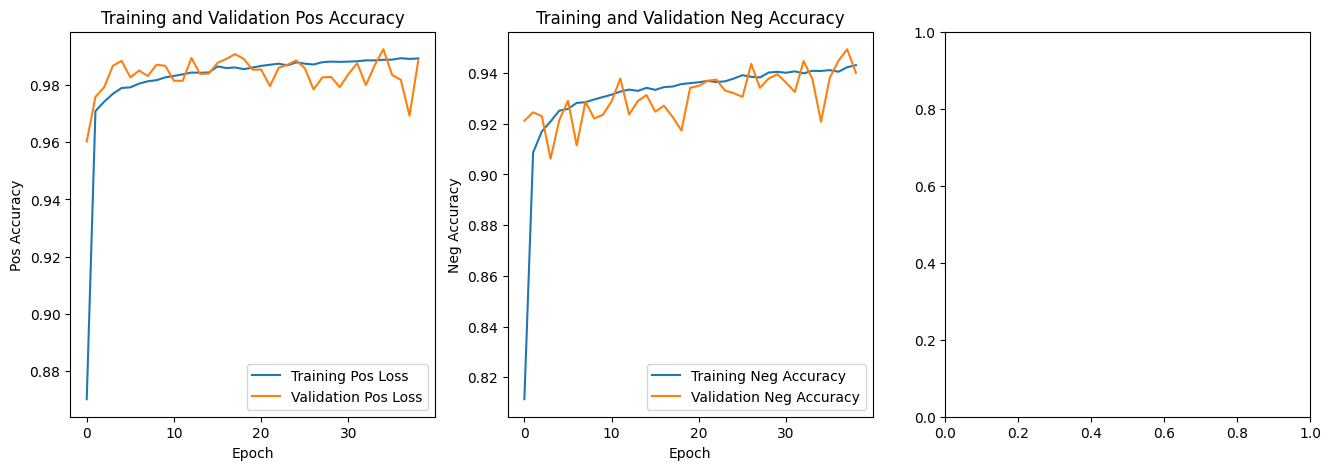

In [25]:
# Accuracy curves
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(train_pos_accuracy_withEpochs, label="Training Pos Loss")
plt.plot(val_pos_accuracy_withEpochs, label="Validation Pos Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Pos Accuracy")
plt.title("Training and Validation Pos Accuracy")


# Plot the training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(train_neg_accuracy_withEpochs, label="Training Neg Accuracy")
plt.plot(val_neg_accuracy_withEpochs, label="Validation Neg Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Neg Accuracy")
plt.title("Training and Validation Neg Accuracy")

# Plot the training and validation accuracy
plt.subplot(1, 3, 3)
plt.plot(train_loss_withEpochs.detach().numpy(), label="Training Accuracy")
plt.plot(val_loss_withEpochs.detach().numpy(), label="Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

plt.show()